# data reading

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import re
import collections
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout

from keras.metrics import categorical_accuracy
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant
from keras.models import Sequential
from keras.optimizers import Adam
from keras import backend as K
import texthero as hero
import plotly.graph_objs as go
from plotly.offline import iplot
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/heda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
TrainData = pd.read_csv('train.csv')
TestData = pd.read_csv('test.csv')

In [4]:
TrainData

textID                                               text sentiment
0      cb774db0d1                I`d have responded, if I were going   neutral
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!  negative
2      088c60f138                          my boss is bullying me...  negative
3      9642c003ef                     what interview! leave me alone  negative
4      358bd9e861   Sons of ****, why couldn`t they put them on t...  negative
...           ...                                                ...       ...
27476  4eac33d1c0   wish we could come see u on Denver  husband l...  negative
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...  negative
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...  positive
27479  ed167662a5                         But it was worth it  ****.  positive
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   neutral

[27481 rows x 3 columns]

# EDA

In [5]:
TrainData.describe()

textID                                             text sentiment
count        27481                                            27480     27481
unique       27481                                            27480         3
top     573239903e  Back from x-men origins . Was surprisingly good   neutral
freq             1                                                1     11118

In [6]:
temp = TrainData.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Greens')

In [7]:
TrainMiss = TrainData.isnull().sum()
print(TrainMiss)

textID       0
text         1
sentiment    0
dtype: int64


In [8]:
TestMiss = TestData.isnull().sum()
print(TestMiss)

textID       0
text         0
sentiment    0
dtype: int64


In [9]:
TrainData['text'].fillna('no words', inplace = True)
TestData['text'].fillna('no words', inplace = True)

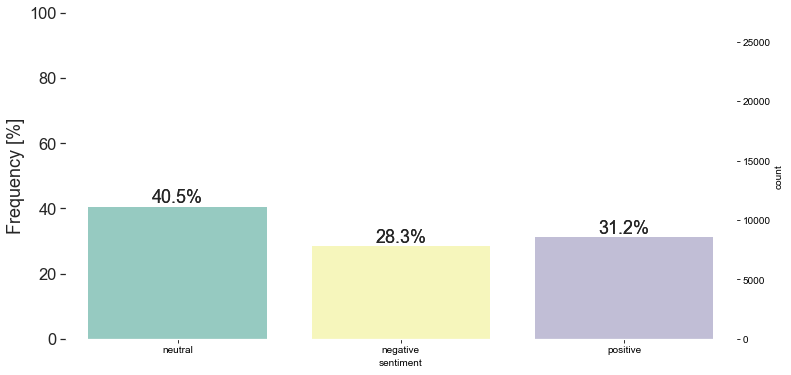

In [10]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=TrainData)
def add_freq():
    ncount=len(TrainData)
    ax2=ax.twinx()
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount),(x.mean(),y),ha='center',va='bottom')
    ax2.set_ylim(0,100)
    ax2.grid(None)
ax=sns.countplot(x='sentiment',data=TrainData,palette='Set3')
sns.set(font_scale=1.5)
ax.set_ylim(top=27481)
add_freq()
plt.show()

In [11]:
TrainData['unclean_text_len'] = TrainData['text'].astype(str).apply(len)
TrainData['unclean_text_word_count'] = TrainData['text'].apply(lambda x: len(str(x).split()))

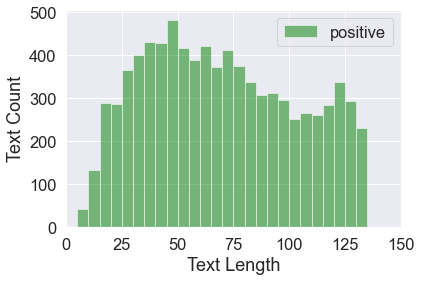

In [12]:
pos = TrainData[TrainData['sentiment']=='positive']
posbins=np.arange(0,138,5)
pos['unclean_text_len'].plot.hist(bins=posbins,color = 'green',alpha=0.5)
plt.xlabel('Text Length')
plt.ylabel('Text Count')
plt.xlim(0,150)
plt.legend(['positive'])
plt.show()

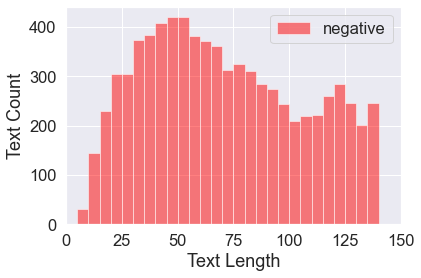

In [13]:
neg = TrainData[TrainData['sentiment']=='negative']
negbins=np.arange(0,141,5)
neg['unclean_text_len'].plot.hist(bins=negbins,color = 'red',alpha=0.5)
plt.xlabel('Text Length')
plt.ylabel('Text Count')
plt.xlim(0,150)
plt.legend(['negative'])
plt.show()

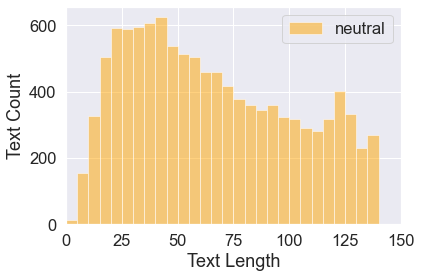

In [14]:
neutral = TrainData[TrainData['sentiment']=='neutral']
neutralbins=np.arange(0,141,5)
neutral['unclean_text_len'].plot.hist(bins=neutralbins,color = 'orange',alpha=0.5)
plt.xlabel('Text Length')
plt.ylabel('Text Count')
plt.xlim(0,150)
plt.legend(['neutral'])
plt.show()

In [15]:
trace0 = go.Box(
    y=pos['unclean_text_len'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['unclean_text_len'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=neutral['unclean_text_len'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")

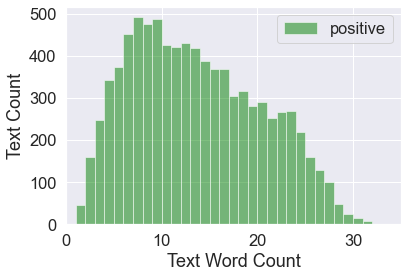

In [16]:
pos = TrainData[TrainData['sentiment']=='positive']
posbins=np.arange(0,33,1)
pos['unclean_text_word_count'].plot.hist(bins=posbins,color = 'green',alpha=0.5)
plt.xlabel('Text Word Count')
plt.ylabel('Text Count')
plt.xlim(0,35)
plt.legend(['positive'])
plt.show()

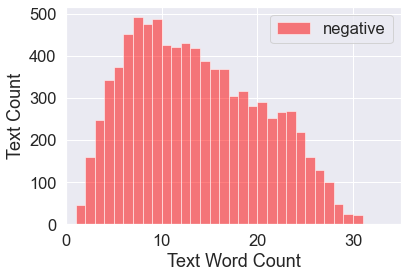

In [17]:
pos = TrainData[TrainData['sentiment']=='positive']
posbins=np.arange(0,32,1)
pos['unclean_text_word_count'].plot.hist(bins=posbins,color = 'red',alpha=0.5)
plt.xlabel('Text Word Count')
plt.ylabel('Text Count')
plt.xlim(0,35)
plt.legend(['negative'])
plt.show()

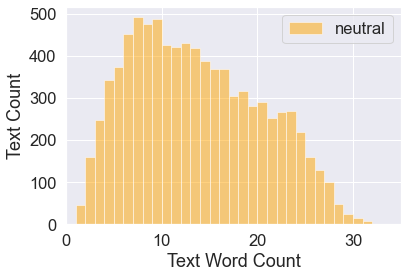

In [18]:
pos = TrainData[TrainData['sentiment']=='positive']
posbins=np.arange(0,33,1)
pos['unclean_text_word_count'].plot.hist(bins=posbins,color = 'orange',alpha=0.5)
plt.xlabel('Text Word Count')
plt.ylabel('Text Count')
plt.xlim(0,35)
plt.legend(['neutral'])
plt.show()

In [19]:
trace0 = go.Box(
    y=pos['unclean_text_word_count'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['unclean_text_word_count'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=neutral['unclean_text_word_count'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "word count of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "word count of the text of different polarities")

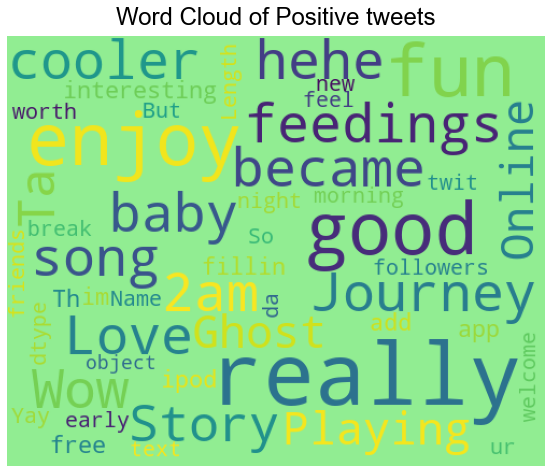

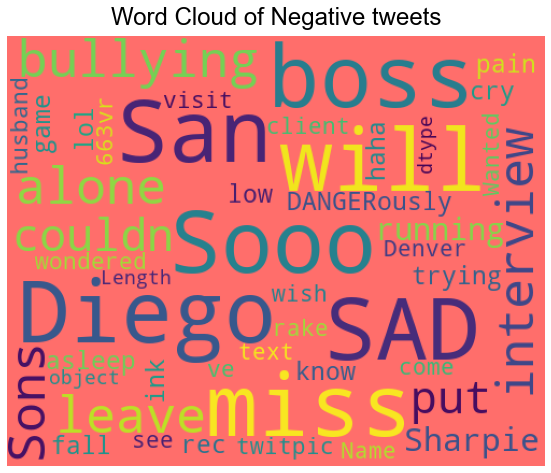

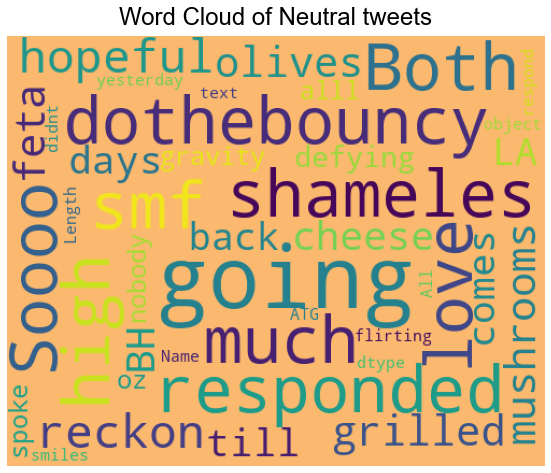

In [20]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=80, figure_size=(8,8), color = 'white',
                   title = None, title_size=24, image_color=False):
    wordcloud = WordCloud(background_color=color,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 666,
                    width=500, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(pos['text'], title="Word Cloud of Positive tweets",color = '#91ed92')
plot_wordcloud(neg['text'], title="Word Cloud of Negative tweets",color = '#ff6e6b')
plot_wordcloud(neutral['text'], title="Word Cloud of Neutral tweets",color = '#fab96e')

# Data cleaning


In [21]:
TrainData['text'] = hero.clean(TrainData['text'])
TrainData['text']

0                                          responded going
1                                  sooo sad miss san diego
2                                            boss bullying
3                                    interview leave alone
4                         sons put releases already bought
                               ...                        
27476    wish could come see u denver husband lost job ...
27477    wondered rake client made clear net force devs...
27478    yay good enjoy break probably need hectic week...
27479                                                worth
27480                   flirting going atg smiles yay hugs
Name: text, Length: 27481, dtype: object

In [22]:
TestData['text'] = hero.clean(TestData['text'])
TestData['text']

0                 last session day http twitpic com 67ezh
1       shanghai also really exciting precisely skyscr...
2       recession hit veronique branquinho quit compan...
3                                              happy bday
4                             http twitpic com 4w75p like
                              ...                        
3529                                   im tired sleep try
3530    alone old house thanks net keeps alive kicking...
3531    know mean little dog sinking depression wants ...
3532           sutra next youtube video gonna love videos
3533        http twitpic com 4woj2 omgssh ang cute ng bby
Name: text, Length: 3534, dtype: object

In [23]:
TrainData

textID                                               text  \
0      cb774db0d1                                    responded going   
1      549e992a42                            sooo sad miss san diego   
2      088c60f138                                      boss bullying   
3      9642c003ef                              interview leave alone   
4      358bd9e861                   sons put releases already bought   
...           ...                                                ...   
27476  4eac33d1c0  wish could come see u denver husband lost job ...   
27477  4f4c4fc327  wondered rake client made clear net force devs...   
27478  f67aae2310  yay good enjoy break probably need hectic week...   
27479  ed167662a5                                              worth   
27480  6f7127d9d7                 flirting going atg smiles yay hugs   

      sentiment  unclean_text_len  unclean_text_word_count  
0       neutral                36                        7  
1      negative                46                       10  
2      negative                25                        5  
3      negative                31                        5  
4      negative                75                       14  
...         ...               ...                      ...  
27476  negative                77                       16  
27477  negative               122                       23  
27478  positive               111                       22  
27479  positive                27                        6  
27480   neutral                62                       11  

[27481 rows x 5 columns]

In [24]:
# stemmer = SnowballStemmer("english")
# def Stemming(text):
#     text = [stemmer.stem(word) for word in text.split()]
#     return ' '.join(text)

# TrainData['text'] = TrainData['text'].apply(lambda x: Stemming(x))
# TestData['text'] = TestData['text'].apply(lambda x: Stemming(x))

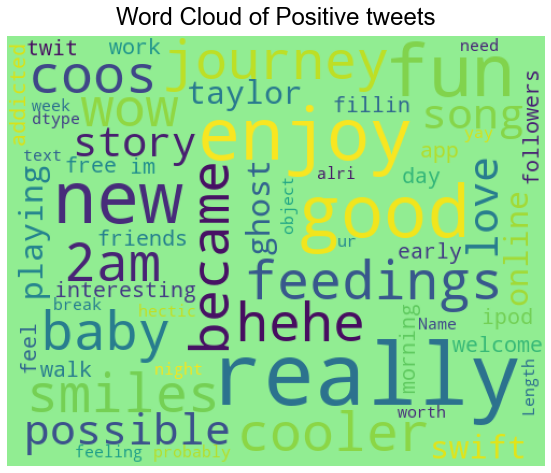

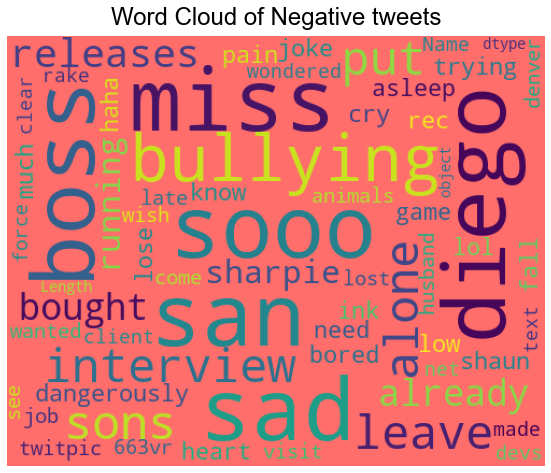

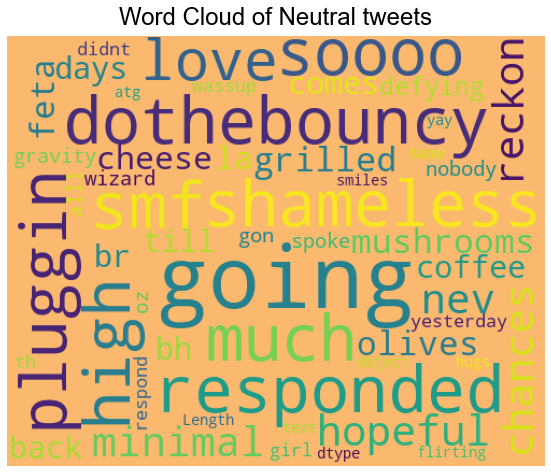

In [25]:
# after stemming
posclean = TrainData[TrainData['sentiment']=='positive']
negclean = TrainData[TrainData['sentiment']=='negative']
neutralclean = TrainData[TrainData['sentiment']=='neutral']
plot_wordcloud(posclean['text'], title="Word Cloud of Positive tweets",color = '#91ed92')
plot_wordcloud(negclean['text'], title="Word Cloud of Negative tweets",color = '#ff6e6b')
plot_wordcloud(neutralclean['text'], title="Word Cloud of Neutral tweets",color = '#fab96e')

In [26]:
# TrainData.to_csv('Cleantrain.csv')
# TestData.to_csv('Cleantest.csv')

In [27]:
TrainTestData = pd.concat([TrainData,TestData])

def CreateTrainTestCorpus(df):
    corpus=[]
    for sentence in df['text']:
        corpus.append(sentence)
    return corpus
        
TrainTestCorpus = CreateTrainTestCorpus(TrainTestData)
TrainTestCorpus

['responded going',
 'sooo sad miss san diego',
 'boss bullying',
 'interview leave alone',
 'sons put releases already bought',
 'http www dothebouncy com smf shameless plugging best rangers forum earth',
 '2am feedings baby fun smiles coos',
 'soooo high',
 '',
 'journey wow u became cooler hehe possible',
 'much love hopeful reckon chances minimal p never gonna get cake stuff',
 'really really like song love story taylor swift',
 'sharpie running dangerously low ink',
 'want go music tonight lost voice',
 'test test lg env2',
 'uh oh sunburned',
 'ok trying plot alternatives speak sigh',
 'sick past days thus hair looks wierd didnt hat would look http tinyurl com mnf4kw',
 'back home gonna miss every one',
 'hes',
 'oh marly sorry hope find soon',
 'playing ghost online really interesting new updates kirin pet metamorph third job wait dragon pet',
 'cleaning house family comming later today',
 'gotta restart computer thought win7 supposed put end constant rebootiness',
 'see wat mea

In [28]:
TrainTestData.to_csv('Label2number.csv')
# change 'positive' to 2 ; 'neutral' to 1 ; 'negative' to '0' in excel
TrainTestData = pd.read_csv('Label2numberFinal.csv')
y_binary = to_categorical(TrainTestData['sentiment'],3)
TrainLabel = y_binary[:TrainData.shape[0]]
TestLabel = y_binary[TrainData.shape[0]:]

In [29]:
PreTrainVector={}
with open('glove.6B.50d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        PreTrainVector[word]=vectors
f.close()

In [30]:
MAX_LEN=25
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(TrainTestCorpus)
sequences=tokenizer_obj.texts_to_sequences(TrainTestCorpus)
text_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
word_index=tokenizer_obj.word_index
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,50))
for word,i in word_index.items():
    if i < num_words:
        emb_vec=PreTrainVector.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec

In [31]:
model=Sequential()
embedding=Embedding(num_words,50,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)
model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
optimzer=Adam(lr=0.02)
model.compile(loss='categorical_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 50)            1368900   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 25, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 1,389,253
Trainable params: 20,353
Non-trainable params: 1,368,900
_________________________________________________________________


In [33]:
train=text_pad[:TrainData.shape[0]]
test=text_pad[TrainData.shape[0]:]
print(train.shape)
print(test.shape)

(27481, 25)
(3534, 25)


In [34]:
Xtrain,Xvalidation,Ytrain,Yvalidation = train_test_split(train,
                                                         TrainLabel,
                                                         test_size = 0.2,
                                                         random_state = 99)
print(Xtrain.shape)
print(Ytrain.shape)

(21984, 25)
(21984, 3)


In [35]:
history = model.fit(Xtrain,Ytrain,batch_size=128,epochs=20,validation_data=(Xvalidation,Yvalidation),verbose=1)

Train on 21984 samples, validate on 5497 samples
Epoch 1/20
21984/21984 [==============================] - 17s 782us/step - loss: 0.9863 - accuracy: 0.5112 - val_loss: 0.8535 - val_accuracy: 0.6340
Epoch 2/20
21984/21984 [==============================] - 15s 700us/step - loss: 0.8969 - accuracy: 0.5894 - val_loss: 0.7931 - val_accuracy: 0.6649
Epoch 3/20
21984/21984 [==============================] - 16s 725us/step - loss: 0.8649 - accuracy: 0.6118 - val_loss: 0.7781 - val_accuracy: 0.6718
Epoch 4/20
21984/21984 [==============================] - 25s 1ms/step - loss: 0.8419 - accuracy: 0.6229 - val_loss: 0.7822 - val_accuracy: 0.6713
Epoch 5/20
21984/21984 [==============================] - 18s 837us/step - loss: 0.8392 - accuracy: 0.6248 - val_loss: 0.7726 - val_accuracy: 0.6755
Epoch 6/20
21984/21984 [==============================] - 18s 839us/step - loss: 0.8289 - accuracy: 0.6329 - val_loss: 0.7599 - val_accuracy: 0.6778
Epoch 7/20
21984/21984 [==============================] - 1

In [101]:
PredTest = model.predict(test)
PredTestTrue = categorical_accuracy(TestLabel,PredTest)
PredTestTrue = K.eval(PredTestTrue)
PredTestTrue = PredTestTrue.sum()
acc = PredTestTrue/3534
print('Test acc:',acc)

Test acc: 0.6946802490096208


In [102]:
TestLabel = TestLabel.astype('int')
TestLabelList = TestLabel.tolist()

In [108]:
PredTestIndex = []
for pre_index in PredTest:
    PredTestIndex.append(np.argmax(pre_index))

TestLabelListIndex = []
for testlabel_index in TestLabelList:
    TestLabelListIndex.append(testlabel_index.index(1))    

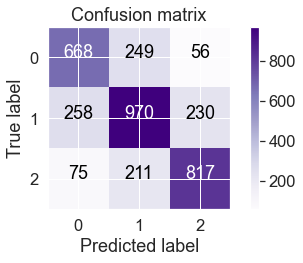

In [128]:
classes = ['0','1','2']
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show
cm = confusion_matrix(PredTestIndex,TestLabelListIndex,labels = None, sample_weight=None)
plot_confusion_matrix(cm,classes)